## 库函数与训练数据的加载

In [19]:
# 导入实验所需的相关库函数
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# 下载实验所需的MNIST数据集
train_dataset = MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

# 查看mnist数据
print(train_dataset)

# 查看是否支持cuda GPU训练
print(torch.cuda.is_available())

# 数据集切分
batch_size = 128
dataIter = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
True


## 代价损失函数：通过俩种不同的方式构建损失函数

In [21]:
# 展平：多维数据展平成低维数据
def flatten(x):
    N = x.shape[0]  # read in N, C, H, W
    return x.view(N, -1)  # torch.Size([128, 784])


# L2损失 (MSE Loss) 构建损失函数
def vae_loss_mse(x, gen_x, mean, log_var):
    # 重构项损失
    mse_loss = torch.nn.MSELoss(reduction='sum')
    loss1 = mse_loss(gen_x, x)

    # 最小化 q(z|x)  和 p(z) 的距离
    KL_loss = 0.5 * torch.sum(torch.exp(log_var) + torch.pow(mean, 2) - log_var - 1)

    return loss1 + KL_loss


# 交叉熵损失 (Cross Entropy Loss) 构建损失函数
def vae_loss_cross(x, gen_x, mean, log_var):
    # 重构项损失
    cross_entropy_loss = F.binary_cross_entropy(reduction='sum')
    loss1 = cross_entropy_loss(gen_x, x)

    # 最小化 q(z|x)  和 p(z) 的距离
    KL_loss = 0.5 * torch.sum(torch.exp(log_var) + torch.pow(mean, 2) - log_var - 1)

    return loss1 + KL_loss

## 构造网络模型
- 采用全连接Dense(Linear)设计网络架构
- 采用卷积层Conv+Dense设计网络架构

### 全连接层——VAE网络

In [22]:
class VariationalAutoEncoder_Dense(nn.Module):
    def __init__(self,
                 image_shape=(1, 28, 28),
                 dense_size=(784, 256, 128),
                 z_dim=20):
        super(VariationalAutoEncoder_Dense, self).__init__()

        # 激活函数
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # encoder全连接层
        self.enDense0 = nn.Linear(dense_size[0], dense_size[1])
        self.enDense1 = nn.Linear(dense_size[1], dense_size[2])

        # 隐变量层
        self.latent_mean = nn.Linear(dense_size[-1], z_dim)
        self.latent_log_var = nn.Linear(dense_size[-1], z_dim)

        # decoder全连接层
        self.deDense0 = nn.Linear(z_dim, dense_size[-1])
        self.deDense1 = nn.Linear(dense_size[-1], dense_size[-2])
        self.deDense2 = nn.Linear(dense_size[-2], dense_size[-3])

        # decoder reshape
        self.dec_reshape = transforms.Lambda(
            lambda x: torch.reshape(x, (x.shape[0], 1, int(image_shape[1]), int(image_shape[2]))))

    # 编码
    def encode(self, x):
        # 展平
        out = flatten(x)
        # 全连接层
        out = self.relu(self.enDense0(out))
        out = self.relu(self.enDense1(out))

        # 均值 mean
        latent_mean = self.latent_mean(out)
        # log方差 log_var
        latent_log_var = self.latent_log_var(out)

        return latent_mean, latent_log_var

    # 重参数化生成隐变量
    def re_parameterize(self, mu, log_var):
        var = torch.exp(log_var)
        epsilon = torch.randn_like(var)
        return mu + torch.mul(var, epsilon)

    # 解码
    def decode(self, z):
        # 全连接层
        out = self.relu(self.deDense0(z))
        out = self.relu(self.deDense1(out))
        out = self.sigmoid(self.deDense2(out))

        # 重构shape
        out = self.dec_reshape(out)

        return out

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        latent_mean, latent_log_var = self.encode(x)
        sampled_Z = self.re_parameterize(latent_mean, latent_log_var)
        Gen_X = self.decode(sampled_Z)
        return latent_mean, latent_log_var, Gen_X

### 卷积层——VAE网络

In [23]:
class VariationalAutoEncoder_Conv(nn.Module):
    def __init__(self,
                 image_shape=(1, 28, 28),
                 conv_size=(1, 6, 16, 4),
                 dense_size=(784, 128),
                 kernel=3,
                 z_dim=20):
        super(VariationalAutoEncoder_Conv, self).__init__()

        # 激活函数
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # encoder卷积层
        # 输入 (128,1,28,28) 输出 (128,6,28,28)
        self.enConv0 = nn.Conv2d(conv_size[0], conv_size[1], kernel, padding=1, padding_mode='replicate')
        # 输入 (128,6,28,28) 输出 (128,16,14,14)
        self.enConv1 = nn.Conv2d(conv_size[1], conv_size[2], kernel, stride=2, padding=1, padding_mode='replicate')
        # 输入 (128,16,14,14) 输出 (128,4,14,14)
        self.enConv2 = nn.Conv2d(conv_size[2], conv_size[3], kernel, padding=1, padding_mode='replicate')

        # encoder全连接层
        self.enDense0 = nn.Linear(dense_size[0], dense_size[1])

        # 隐变量层
        self.latent_mean = nn.Linear(dense_size[-1], z_dim)
        self.latent_log_var = nn.Linear(dense_size[-1], z_dim)

        # decoder全连接层
        self.deDense0 = nn.Linear(z_dim, dense_size[-1])
        self.deDense1 = nn.Linear(dense_size[-1], dense_size[-2])
        self.deDense2 = nn.Linear(dense_size[-2], int(np.prod(image_shape)))

        # 需要对 全连接层输出的一维结果数据 进行 reshape
        self.dec_reshape = transforms.Lambda(
            lambda x: torch.reshape(x, (x.shape[0], 1, int(image_shape[1]), int(image_shape[2]))))

    # 编码
    def encode(self, x):
        # 卷积层
        out = self.relu(self.enConv0(x))
        out = self.relu(self.enConv1(out))
        out = self.relu(self.enConv2(out))

        # 展平
        out = flatten(out)

        # 全连接层
        out = self.relu(self.enDense0(out))

        # 均值 mean
        latent_mean = self.latent_mean(out)
        # log方差 log_var
        latent_log_var = self.latent_log_var(out)

        return latent_mean, latent_log_var

    # 重参数化生成隐变量
    def re_parameterize(self, mu, log_var):
        var = torch.exp(log_var)
        epsilon = torch.randn_like(var)
        return mu + torch.mul(var, epsilon)

    # 解码
    def decode(self, z):
        # 全连接层
        out = self.relu(self.deDense0(z))
        out = self.relu(self.deDense1(out))
        out = self.sigmoid(self.deDense2(out))

        # 重构shape
        out = self.dec_reshape(out)

        return out

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        latent_mean, latent_log_var = self.encode(x)
        sampled_Z = self.re_parameterize(latent_mean, latent_log_var)
        Gen_X = self.decode(sampled_Z)
        return latent_mean, latent_log_var, Gen_X

## 查看网络结构

In [24]:
# 网络训练设备：建议使用cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 利用summary函数查看网络的层次结构
print("==========================VAE(Dense)网络结构==========================")
model_Dense = VariationalAutoEncoder_Dense()
model_Dense.to(device)
summary(model_Dense, input_size=(1, 28, 28))
print("==========================VAE(Conv)网络结构==========================")
model_Conv = VariationalAutoEncoder_Conv()
model_Conv.to(device)
summary(model_Conv, input_size=(1, 28, 28))

==========================VAE(Dense)网络结构==========================
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 20]           2,580
            Linear-6                   [-1, 20]           2,580
            Linear-7                  [-1, 128]           2,688
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 256]          33,024
             ReLU-10                  [-1, 256]               0
           Linear-11                  [-1, 784]         201,488
          Sigmoid-12                  [-1, 784]               0
Total params: 476,216
Trainable para

## 设定模型参数

In [25]:
# 训练模型参数
learning_rate = 1e-3  # 学习率
epoches = 10  # 迭代次数

# 实例化模型 二选一 即可
model = model_Conv
# model = model_Dense

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 模型训练

In [26]:
train_loss = []  # 保存每个epoch的训练误差
number = len(dataIter.dataset)
result_dir = './VAEResult' # 保存生成图片的目录

for epoch in range(epoches):
    batch_loss = []
    for i, (x, y) in enumerate(dataIter):
        x = x.to(device)  # gpu训练

        # 前向传播
        mean, log_var, gen_x = model(x)

        # 计算损失函数 二选一 即可
        loss = vae_loss_mse(x, gen_x, mean, log_var)
        # loss = vae_loss_cross(x, gen_x, mean, log_var)
        batch_loss.append(loss.item())

        # 反向传播和优化
        optimizer.zero_grad()  # 每一次循环之前，将梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 梯度下降

        # 输出batch信息
        if i % 100 == 0 and i > 0:
            print("epoch : {0} | batch : {1} | batch average loss: {2}"
                  .format(epoch + 1, i, loss.item() / x.shape[0]))

        # 保存 各个epoch下 VAE的生成效果图
        if i == 0:
            x_concatD = torch.cat([x.view(-1, 1, 28, 28), gen_x.view(-1, 1, 28, 28)], dim=3)
            save_image(x_concatD, './%s/reconstructed-%d.png' % (result_dir, epoch + 1))

    # 输出epoch信息
    train_loss.append(np.sum(batch_loss) / number)
    print("epoch[{}/{}] | loss:{}"
          .format(epoch + 1, epoches, train_loss[epoch]))

epoch : 1 | batch : 100 | batch average loss: 56.1246223449707
epoch : 1 | batch : 200 | batch average loss: 50.71028137207031
epoch : 1 | batch : 300 | batch average loss: 47.44122314453125
epoch : 1 | batch : 400 | batch average loss: 43.33039093017578
epoch[1/5] | loss:50.30060262044271
epoch : 2 | batch : 100 | batch average loss: 35.79652786254883
epoch : 2 | batch : 200 | batch average loss: 33.91908645629883
epoch : 2 | batch : 300 | batch average loss: 30.508880615234375
epoch : 2 | batch : 400 | batch average loss: 31.092205047607422
epoch[2/5] | loss:32.60229806315104
epoch : 3 | batch : 100 | batch average loss: 29.826305389404297
epoch : 3 | batch : 200 | batch average loss: 30.443077087402344
epoch : 3 | batch : 300 | batch average loss: 29.97263526916504
epoch : 3 | batch : 400 | batch average loss: 30.899505615234375
epoch[3/5] | loss:29.209166223144532
epoch : 4 | batch : 100 | batch average loss: 28.579774856567383
epoch : 4 | batch : 200 | batch average loss: 27.79596

## evaluation 测试生成效果

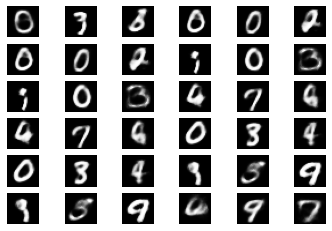

In [27]:
# 从正态分布随机采样z
z = torch.randn((batch_size, 20)).to(device)
logits = model.decode(z)  # 仅通过解码器生成图片
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy() * 255.
# 展示图片
_, axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off')
        axes[i][j].imshow(x_hat[i * 3 + j], cmap='gray')
plt.show()